In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

# Paths
u_file = '/Users/jure/PhD/coding/RICO_1hr/rico.u.nc'
v_file = '/Users/jure/PhD/coding/RICO_1hr/rico.v.nc'
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'

# Wind output investigation

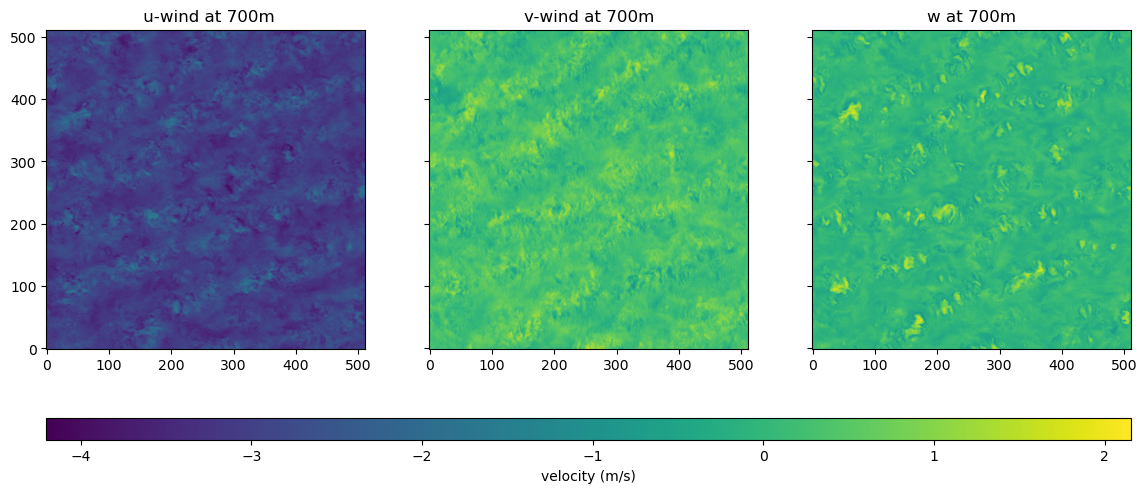

In [2]:
desired_height = 700
timestep = 10

def load_data_at_height(filename, var_name, timestep, height, vertical_dim_name):
    with nc.Dataset(filename) as ds:
        vertical_levels = ds[vertical_dim_name][:]
        idx = (np.abs(vertical_levels - height)).argmin()
        var_data = ds[var_name][timestep, idx, :, :]  # Extract 2D slice at the specified height
    return var_data

u_wind = load_data_at_height(u_file, 'u', timestep, desired_height, 'zt')
v_wind = load_data_at_height(v_file, 'v', timestep, desired_height, 'zt')
w_wind = load_data_at_height(w_file, 'w', timestep, desired_height, 'zm')

# Determine global min and max values for consistent color scaling
all_data = np.stack([u_wind, v_wind, w_wind])
vmin, vmax = all_data.min(), all_data.max()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(14, 6), sharex=True, sharey=True)

cmap = 'viridis'
im = axs[0].imshow(u_wind, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
axs[0].set_title(f' u-wind at {desired_height}m')

axs[1].imshow(v_wind, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
axs[1].set_title(f'v-wind at {desired_height}m')

axs[2].imshow(w_wind, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
axs[2].set_title(f'w at {desired_height}m')

fig.colorbar(im, ax=axs, orientation='horizontal', aspect=50, label = 'velocity (m/s)')
plt.show()



## Mean profiles of u,v wind fields for different timesteps

The plots below show that as the simulation develops the horizontal field near the surface tends to decrease. This might point to an issue in UCLA-LES forcing. 

In [3]:
def load_wind_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        wind_data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
        zt_values = ds['zt'][:]
    return wind_data, zt_values

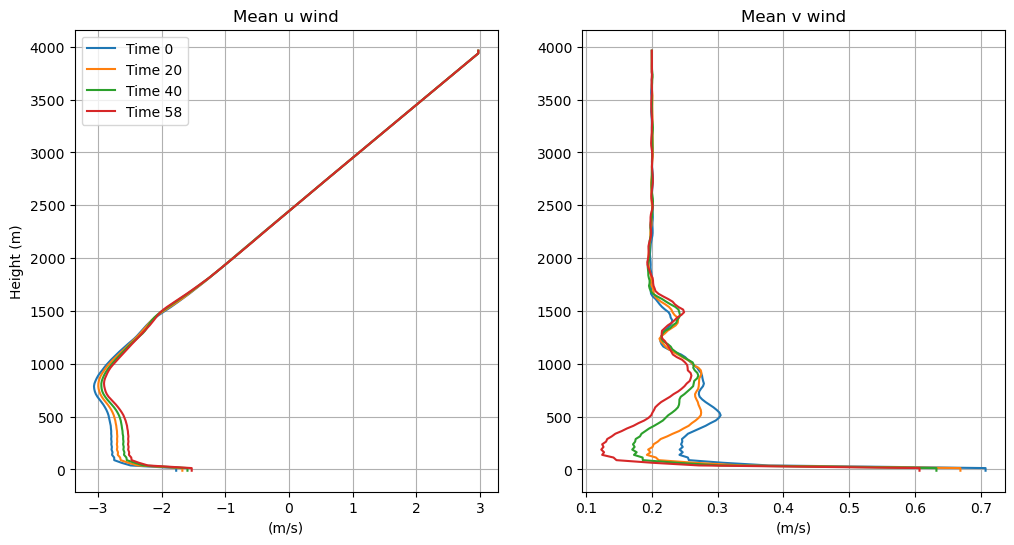

In [4]:
timesteps = [0, 20, 40, 58]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Loop over timesteps
for timestep in timesteps:
    u_wind_data, zt_values = load_wind_all_levels(u_file, 'u', timestep)
    u_wind_means = np.mean(u_wind_data, axis=(1, 2))  # Mean over both horizontal dimensions
    axs[0].plot(u_wind_means, zt_values, label=f'Time {timestep}')
    
    v_wind_data, zt_values = load_wind_all_levels(v_file, 'v', timestep)
    v_wind_means = np.mean(v_wind_data, axis=(1, 2))
    axs[1].plot(v_wind_means, zt_values)

axs[0].set_xlabel('(m/s)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('Mean u wind')
axs[0].grid(True)
axs[0].legend()
axs[1].set_xlabel('(m/s)')
axs[1].set_title('Mean v wind')
axs[1].grid(True)
plt.savefig(os.path.join('analysis_plots', 'mean_horizontal_wind_time_variation.pdf'), format='pdf', bbox_inches='tight')

## Field mean u and v wind with variance for a given timestep
Taking the field average (for each height level). Much larger variability in v-wind. The absolute sigma variation is similar: the visual is misleading as the x-axis scale is different between the two plots. 

In [5]:
# set parameters for next few plots

timestep = 50
sigma_level = 2 # sigma level: 1 for 1σ, 2 for 2σ etc

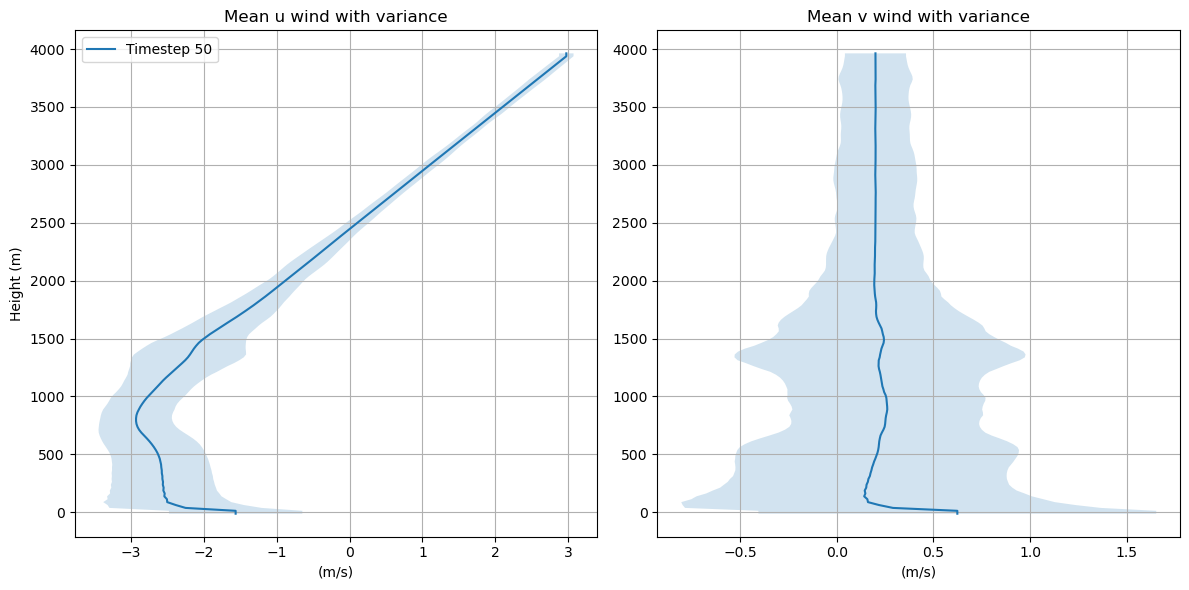

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

u_wind_data, zt_values = load_wind_all_levels(u_file, 'u', timestep)
u_wind_means = np.mean(u_wind_data, axis=(1, 2))  # Mean over both horizontal dimensions
u_wind_std = np.std(u_wind_data, axis=(1, 2))  # Standard deviation over both horizontal dimensions

v_wind_data, zt_values = load_wind_all_levels(v_file, 'v', timestep)
v_wind_means = np.mean(v_wind_data, axis=(1, 2))
v_wind_std = np.std(v_wind_data, axis=(1, 2))

axs[0].plot(u_wind_means, zt_values, label=f'Timestep {timestep}')
axs[0].fill_betweenx(zt_values, u_wind_means - sigma_level * u_wind_std, u_wind_means + sigma_level * u_wind_std, alpha=0.2)

axs[1].plot(v_wind_means, zt_values)
axs[1].fill_betweenx(zt_values, v_wind_means - sigma_level * v_wind_std, v_wind_means + sigma_level * v_wind_std, alpha=0.2)

axs[0].set_xlabel('(m/s)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('Mean u wind with variance')
axs[0].grid(True)
axs[0].legend()
axs[1].set_xlabel('(m/s)')
axs[1].set_title('Mean v wind with variance')
axs[1].grid(True)
plt.tight_layout()
plt.show()


## Comparison with cloudy part of u and v field. 

Averaging u and v fields only for liquid water points. 

In [7]:
# load liquid water field
l_dataset = nc.Dataset("/Users/jure/PhD/coding/RICO_1hr/rico.l.nc", 'r')
l_data = l_dataset.variables['l'][timestep, :, :, :]

# liquid water threshold
threshold_value = 0.0001

# Find cloudy indices
indices = np.where(l_data > threshold_value)

Sanity check to see if the clouds mask is doing the correct thing. 

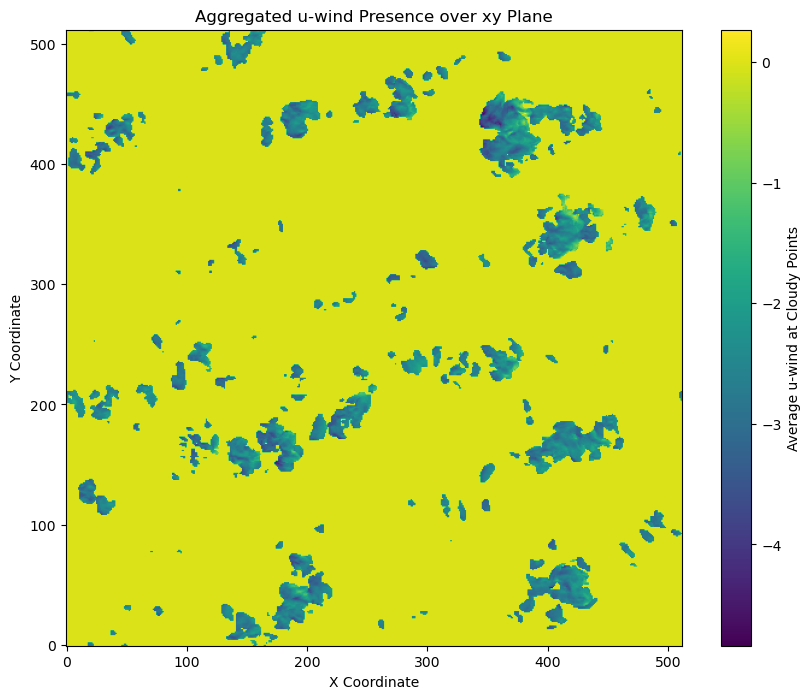

In [8]:
u_wind_at_cloudy = u_wind_data[indices]

# aggregate u-wind at cloudy points by averaging over all heights for each xy location.
u_wind_aggregated = np.zeros(l_data.shape[1:3])
count = np.zeros_like(u_wind_aggregated)

for z, y, x in zip(*indices):
    u_wind_aggregated[y, x] += u_wind_data[z, y, x]  # Summing up u-wind values
    count[y, x] += 1

# Avoid division by zero for places with no cloudy points
count[count == 0] = 1
u_wind_aggregated /= count  # Averaging

# Plotting
plt.figure(figsize=(10, 8))
plt.imshow(u_wind_aggregated, cmap='viridis', origin='lower')
plt.colorbar(label='Average u-wind at Cloudy Points')
plt.title('Aggregated u-wind Presence over xy Plane')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

Define function that calculates mean and standard deviation of wind at cloudy points at each height level to compare with field average

In [9]:
def stats_wind_cloudy_points(wind_data, cloudy_indices, zt_dim_size):
    '''calculate mean and standard deviation of wind at cloudy points at each height level'''
    mean_wind = np.zeros(zt_dim_size)
    std_wind = np.zeros(zt_dim_size)
    for i in range(zt_dim_size):
        mask = (cloudy_indices[0] == i)
        if np.any(mask):
            filtered_wind = wind_data[i, cloudy_indices[1][mask], cloudy_indices[2][mask]]
            mean_wind[i] = np.mean(filtered_wind)
            std_wind[i] = np.std(filtered_wind)
        else:
            mean_wind[i] = np.nan
            std_wind[i] = np.nan
    return mean_wind, std_wind

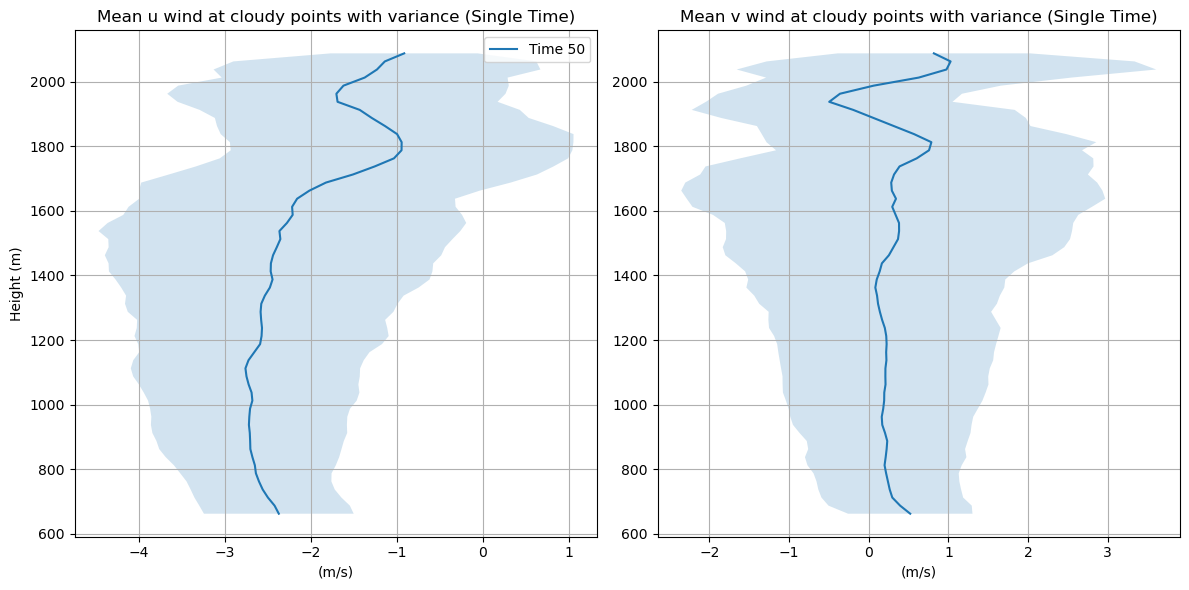

In [10]:
# Calculate mean and standard deviation for u and v wind over cloudy points
u_wind_mean_cloudy, u_wind_std_cloudy = stats_wind_cloudy_points(u_wind_data, indices, len(zt_values))
v_wind_mean_cloudy, v_wind_std_cloudy = stats_wind_cloudy_points(v_wind_data, indices, len(zt_values))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(u_wind_mean_cloudy, zt_values, label=f'Time {timestep}')
axs[0].fill_betweenx(zt_values, u_wind_mean_cloudy - sigma_level * u_wind_std_cloudy, u_wind_mean_cloudy + sigma_level * u_wind_std_cloudy, alpha=0.2)
axs[0].set_xlabel('(m/s)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('Mean u wind at cloudy points with variance (Single Time)')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(v_wind_mean_cloudy, zt_values)
axs[1].fill_betweenx(zt_values, v_wind_mean_cloudy - sigma_level * v_wind_std_cloudy, v_wind_mean_cloudy + sigma_level * v_wind_std_cloudy, alpha=0.2)
axs[1].set_xlabel('(m/s)')
axs[1].set_title('Mean v wind at cloudy points with variance (Single Time)')
axs[1].grid(True)
plt.tight_layout()
plt.show()

### Compare at a given timestep

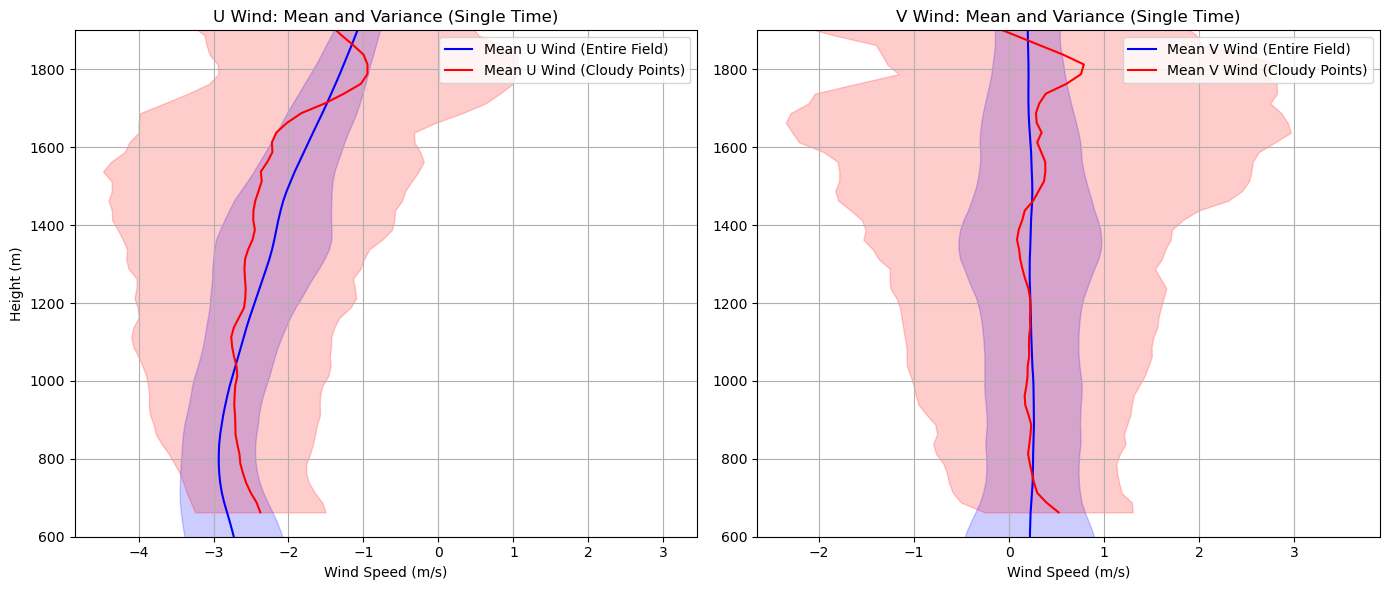

In [11]:
# Plotting
y_axis_lower_limit = 600
y_axis_upper_limit = 1900

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(u_wind_means, zt_values, label='Mean U Wind (Entire Field)', color='blue')
axs[0].fill_betweenx(zt_values, u_wind_means - sigma_level * u_wind_std, 
                     u_wind_means + sigma_level * u_wind_std, alpha=0.2, color='blue')
axs[0].plot(u_wind_mean_cloudy, zt_values, label='Mean U Wind (Cloudy Points)', color='red')
axs[0].fill_betweenx(zt_values, u_wind_mean_cloudy - sigma_level * u_wind_std_cloudy, 
                     u_wind_mean_cloudy + sigma_level * u_wind_std_cloudy, alpha=0.2, color='red')
axs[0].set_ylim(y_axis_lower_limit, y_axis_upper_limit)
axs[0].set_xlabel('Wind Speed (m/s)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('U Wind: Mean and Variance (Single Time)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(v_wind_means, zt_values, label='Mean V Wind (Entire Field)', color='blue')
axs[1].fill_betweenx(zt_values, v_wind_means - sigma_level * v_wind_std, 
                     v_wind_means + sigma_level * v_wind_std, alpha=0.2, color='blue')
axs[1].plot(v_wind_mean_cloudy, zt_values, label='Mean V Wind (Cloudy Points)', color='red')
axs[1].fill_betweenx(zt_values, v_wind_mean_cloudy - sigma_level * v_wind_std_cloudy, 
                     v_wind_mean_cloudy + sigma_level * v_wind_std_cloudy, alpha=0.2, color='red')
axs[1].set_ylim(y_axis_lower_limit, y_axis_upper_limit)
axs[1].set_xlabel('Wind Speed (m/s)')
axs[1].set_title('V Wind: Mean and Variance (Single Time)')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.savefig(os.path.join('analysis_plots', 'cloudy_vs_full_field_horizontal_wind.pdf'), format='pdf', bbox_inches='tight')


### Average over multiple timesteps

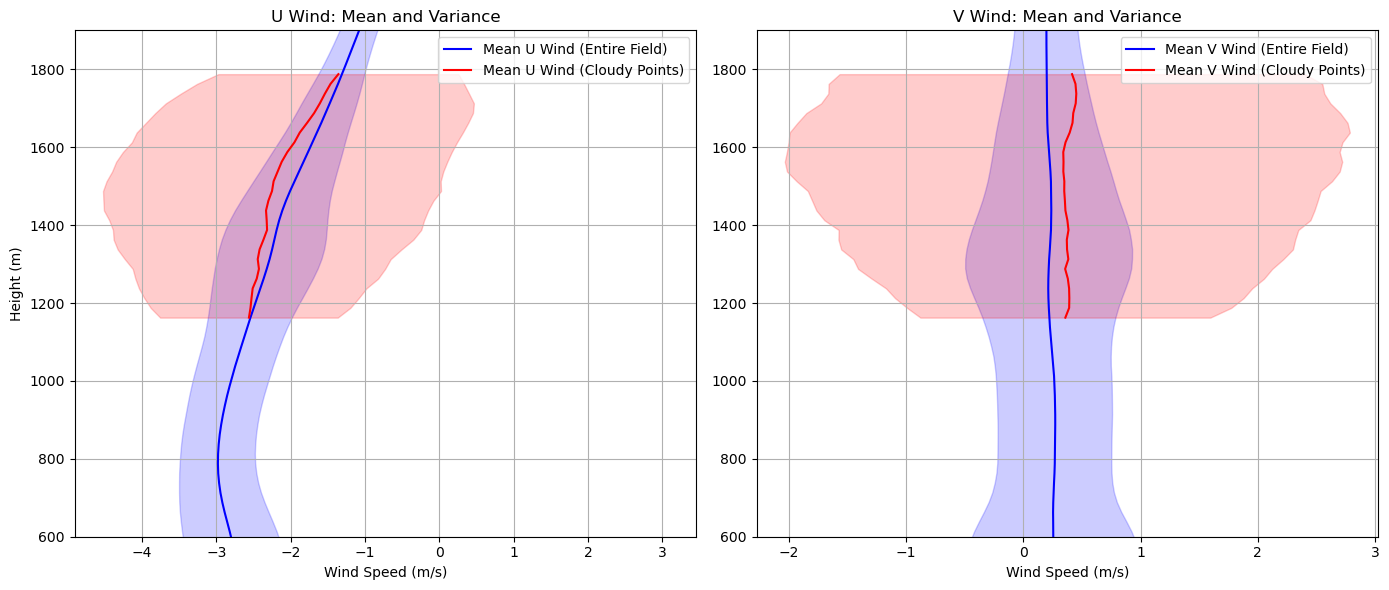

In [12]:
timesteps = list(range(10,50))

# Initialize accumulators
u_wind_mean_cloudy_accum = u_wind_std_cloudy_accum = None
v_wind_mean_cloudy_accum = v_wind_std_cloudy_accum = None
u_wind_mean_accum = u_wind_std_accum = None
v_wind_mean_accum = v_wind_std_accum = None

n_timesteps = len(timesteps)
for timestep in timesteps:
    l_dataset = nc.Dataset("/Users/jure/PhD/coding/RICO_1hr/rico.l.nc", 'r')  # Update the path accordingly
    l_data = l_dataset.variables['l'][timestep, :, :, :]
    threshold_value = 0.001
    indices = np.where(l_data > threshold_value)
    
    u_wind_data, zt_values = load_wind_all_levels(u_file, 'u', timestep)
    v_wind_data, _ = load_wind_all_levels(v_file, 'v', timestep)
    
    u_wind_mean_cloudy, u_wind_std_cloudy = stats_wind_cloudy_points(u_wind_data, indices, len(zt_values))
    v_wind_mean_cloudy, v_wind_std_cloudy = stats_wind_cloudy_points(v_wind_data, indices, len(zt_values))
    
    u_wind_means = np.mean(u_wind_data, axis=(1, 2))
    u_wind_std = np.std(u_wind_data, axis=(1, 2))
    v_wind_means = np.mean(v_wind_data, axis=(1, 2))
    v_wind_std = np.std(v_wind_data, axis=(1, 2))
    
    # Accumulate
    if u_wind_mean_cloudy_accum is None:
        # Initialize accumulators
        u_wind_mean_cloudy_accum, u_wind_std_cloudy_accum = u_wind_mean_cloudy, u_wind_std_cloudy
        v_wind_mean_cloudy_accum, v_wind_std_cloudy_accum = v_wind_mean_cloudy, v_wind_std_cloudy
        u_wind_mean_accum, u_wind_std_accum = u_wind_means, u_wind_std
        v_wind_mean_accum, v_wind_std_accum = v_wind_means, v_wind_std
    else:
        # Accumulate
        u_wind_mean_cloudy_accum += u_wind_mean_cloudy
        u_wind_std_cloudy_accum += u_wind_std_cloudy
        v_wind_mean_cloudy_accum += v_wind_mean_cloudy
        v_wind_std_cloudy_accum += v_wind_std_cloudy
        u_wind_mean_accum += u_wind_means
        u_wind_std_accum += u_wind_std
        v_wind_mean_accum += v_wind_means
        v_wind_std_accum += v_wind_std

# Calculate the overall average
u_wind_mean_cloudy_avg = u_wind_mean_cloudy_accum / n_timesteps
u_wind_std_cloudy_avg = u_wind_std_cloudy_accum / n_timesteps
v_wind_mean_cloudy_avg = v_wind_mean_cloudy_accum / n_timesteps
v_wind_std_cloudy_avg = v_wind_std_cloudy_accum / n_timesteps
u_wind_mean_avg = u_wind_mean_accum / n_timesteps
u_wind_std_avg = u_wind_std_accum / n_timesteps
v_wind_mean_avg = v_wind_mean_accum / n_timesteps
v_wind_std_avg = v_wind_std_accum / n_timesteps




# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# U Wind Plot
axs[0].plot(u_wind_mean_avg, zt_values, label='Mean U Wind (Entire Field)', color='blue')
axs[0].fill_betweenx(zt_values, u_wind_mean_avg - sigma_level * u_wind_std_avg, 
                     u_wind_mean_avg + sigma_level * u_wind_std_avg, alpha=0.2, color='blue')
axs[0].plot(u_wind_mean_cloudy_avg, zt_values, label='Mean U Wind (Cloudy Points)', color='red')
axs[0].fill_betweenx(zt_values, u_wind_mean_cloudy_avg - sigma_level * u_wind_std_cloudy_avg, 
                     u_wind_mean_cloudy_avg + sigma_level * u_wind_std_cloudy_avg, alpha=0.2, color='red')
axs[0].set_ylim(y_axis_lower_limit, y_axis_upper_limit)
axs[0].set_xlabel('Wind Speed (m/s)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('U Wind: Mean and Variance')
axs[0].legend()
axs[0].grid(True)

# V Wind Plot
axs[1].plot(v_wind_mean_avg, zt_values, label='Mean V Wind (Entire Field)', color='blue')
axs[1].fill_betweenx(zt_values, v_wind_mean_avg - sigma_level * v_wind_std_avg, 
                     v_wind_mean_avg + sigma_level * v_wind_std_avg, alpha=0.2, color='blue')
axs[1].plot(v_wind_mean_cloudy_avg, zt_values, label='Mean V Wind (Cloudy Points)', color='red')
axs[1].fill_betweenx(zt_values, v_wind_mean_cloudy_avg - sigma_level * v_wind_std_cloudy_avg, 
                     v_wind_mean_cloudy_avg + sigma_level * v_wind_std_cloudy_avg, alpha=0.2, color='red')
axs[1].set_ylim(y_axis_lower_limit, y_axis_upper_limit)
axs[1].set_xlabel('Wind Speed (m/s)')
axs[1].set_title('V Wind: Mean and Variance')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_92166/961648453.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  colorbar.ax.set_yticklabels(['{:.2f}'.format(x) for x in colorbar.get_ticks()])  # Format tick labels


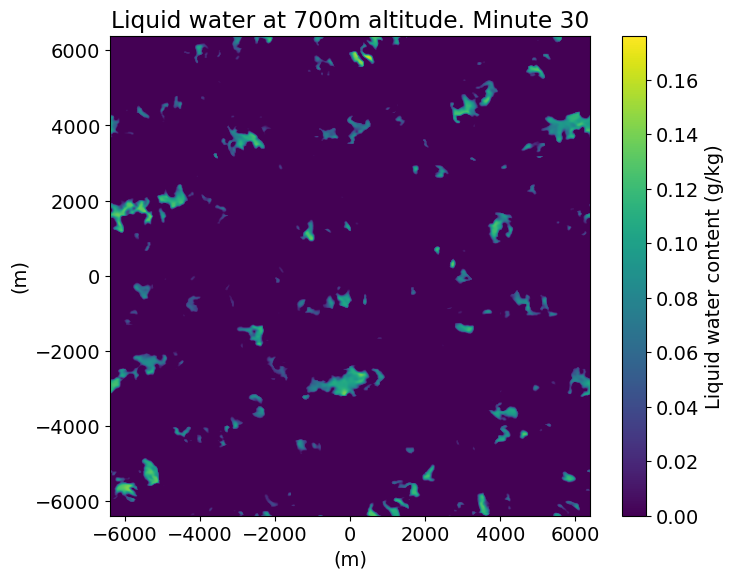

In [36]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define the path to the liquid water content file
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'

desired_height = 700

def load_data_at_height(filename, var_name, timestep, height, vertical_dim_name):
    with nc.Dataset(filename) as ds:
        vertical_levels = ds[vertical_dim_name][:]
        idx = (np.abs(vertical_levels - height)).argmin()
        var_data = ds[var_name][timestep, idx, :, :] * 1000  # Extract 2D slice at the specified height
        xt = ds['xt'][:]  # x-coordinates
        yt = ds['yt'][:]  # y-coordinates
    return var_data, xt, yt

def update(frame):
    ax.clear()
    l_data, xt, yt = load_data_at_height(l_file, 'l', frame, desired_height, 'zt')
    im = ax.imshow(l_data, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax, extent=[xt.min(), xt.max(), yt.min(), yt.max()])
    ax.set_title(f'Liquid water at {desired_height}m altitude. Minute {frame}')  # Title added back
    ax.set_xlabel('(m)')
    ax.set_ylabel('(m)')
    return im,

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
cmap = 'viridis'
plt.rcParams.update({'font.size': 14})  # Increase font size by 1.5 times
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)  # Adjust subplot edges

# Set fewer ticks on the coordinates
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

# Determine min and max values for color scaling across all timesteps
num_timesteps = 31  # Set the number of timesteps you want to plot
l_min = []
l_max = []
for i in range(num_timesteps):
    l_temp, _, _ = load_data_at_height(l_file, 'l', i, desired_height, 'zt')
    l_min.append(l_temp.min())
    l_max.append(l_temp.max())
vmin = min(l_min)
vmax = max(l_max)

# Create an animation
ani = FuncAnimation(fig, update, frames=num_timesteps, blit=True)

# Adjust color limits more tightly and add a colorbar
im = ax.imshow(np.zeros((10, 10)), cmap=cmap, vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])  # Dummy image for colorbar
colorbar = fig.colorbar(im, ax=ax, orientation='vertical', label='Liquid water content (g/kg)')
colorbar.ax.set_yticklabels(['{:.2f}'.format(x) for x in colorbar.get_ticks()])  # Format tick labels

# Save animation
ani.save('liquid_water_content.mp4', writer='ffmpeg', fps=1.5)

plt.show()


# Side-on liquid water


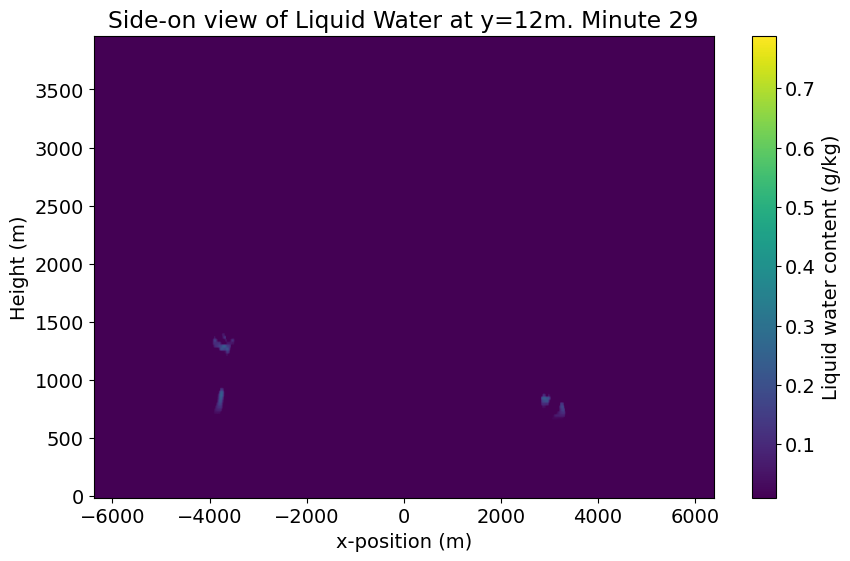

In [31]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --- Parameters ---
L_FILE = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
NUM_TIMESTEPS = 30  # Number of timesteps for the animation

def load_vertical_slice(filename, var_name, timestep, y_idx):
    """Loads a vertical (x-z) slice of a variable at a specific y-index."""
    with nc.Dataset(filename) as ds:
        # Extract 2D slice at the specified y-index
        var_data = ds[var_name][timestep, :, y_idx, :] * 1000  # Convert to g/kg
        xt = ds['xt'][:]  # x-coordinates
        zt = ds['zt'][:]  # z-coordinates (vertical)
    return var_data, xt, zt

# --- Pre-computation for color limits and slice index ---
vmin, vmax = np.inf, -np.inf
y_slice_idx = 0
y_coord = 0

# Open the file once to determine the middle y-index and global color limits
with nc.Dataset(L_FILE) as ds:
    yt = ds['yt'][:]
    y_slice_idx = len(yt) // 2
    y_coord = yt[y_slice_idx]
    
    # ToDo (optimisation)
    # This loop reads data slices repeatedly. For very large files,
    # loading the whole variable once might be faster if memory allows.
    for i in range(NUM_TIMESTEPS):
        # Slicing inside the loop to find min/max
        l_temp = ds['l'][i, :, y_slice_idx, :] * 1000
        if l_temp.size > 0:
            vmin = min(vmin, l_temp.min())
            vmax = max(vmax, l_temp.max())

# --- Animation Setup ---
fig, ax = plt.subplots(figsize=(10, 6))
cmap = 'viridis'
plt.rcParams.update({'font.size': 14})

def update(frame):
    """Function to update the plot for each animation frame."""
    ax.clear()
    l_data, xt, zt = load_vertical_slice(L_FILE, 'l', frame, y_slice_idx)
    
    # Use a low value for vmin to highlight cloud structures
    display_vmin = 0.01
    
    im = ax.imshow(l_data, cmap=cmap, origin='lower', 
                   vmin=display_vmin, vmax=vmax, 
                   extent=[xt.min(), xt.max(), zt.min(), zt.max()],
                   aspect='auto')
                   
    ax.set_title(f'Side-on view of Liquid Water at y={y_coord:.0f}m. Minute {frame}')
    ax.set_xlabel('x-position (m)')
    ax.set_ylabel('Height (m)')
    return [im]

# Create the animation
ani = FuncAnimation(fig, update, frames=NUM_TIMESTEPS, blit=True)

# Add a colorbar
dummy_im = ax.imshow(np.zeros((2,2)), cmap=cmap, vmin=0.01, vmax=vmax)
colorbar = fig.colorbar(dummy_im, ax=ax, orientation='vertical', label='Liquid water content (g/kg)')

# Save the animation
ani.save('liquid_water_content_side_on.mp4', writer='ffmpeg', fps=1.5, dpi=150)

plt.show()

# Side-on, horizontal sum

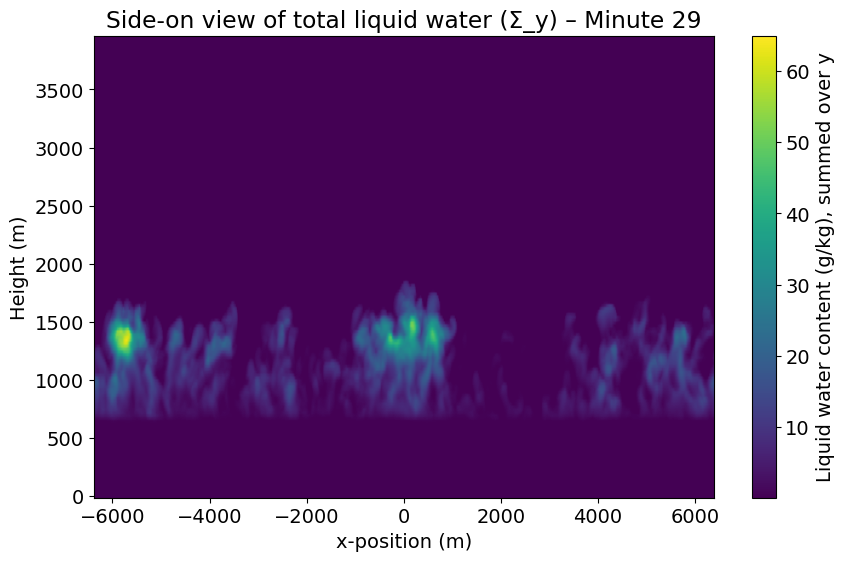

In [ ]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --- Parameters ---
L_FILE = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
VAR_NAME = 'l'          # liquid water mixing ratio
NUM_TIMESTEPS = 3      # number of timesteps for the animation
FACTOR = 1000           # kg/kg -> g/kg

def load_sum_over_y(filename, var_name, timestep):
    """Returns x–z field of var summed over y for one timestep."""
    with nc.Dataset(filename) as ds:
        # ds[var_name][t, z, y, x]; sum over axis=2 (y)
        var_sum = ds[var_name][timestep, :, :, :].sum(axis=1) * FACTOR
        xt = ds['xt'][:]
        zt = ds['zt'][:]
    return var_sum, xt, zt

# --- Precompute global color limits over requested frames ---
vmin, vmax = np.inf, -np.inf
with nc.Dataset(L_FILE) as ds:
    for i in range(NUM_TIMESTEPS):
        l_tmp = ds[VAR_NAME][i, :, :, :].sum(axis=1) * FACTOR
        if l_tmp.size:
            vmin = min(vmin, l_tmp.min())
            vmax = max(vmax, l_tmp.max())

# --- Animation setup ---
fig, ax = plt.subplots(figsize=(10, 6))
cmap = 'viridis'
plt.rcParams.update({'font.size': 14})
display_vmin = 0.01  # keep low to highlight small amounts

def update(frame):
    ax.clear()
    l_data, xt, zt = load_sum_over_y(L_FILE, VAR_NAME, frame)
    im = ax.imshow(l_data, cmap=cmap, origin='lower',
                   vmin=display_vmin, vmax=vmax,
                   extent=[xt.min(), xt.max(), zt.min(), zt.max()],
                   aspect='auto')
    ax.set_title(f'Side-on view of total liquid water (Σ_y) – Minute {frame}')
    ax.set_xlabel('x-position (m)')
    ax.set_ylabel('Height (m)')
    return [im]

ani = FuncAnimation(fig, update, frames=NUM_TIMESTEPS, blit=True)

# Colorbar (use a dummy mappable so it stays constant)
dummy_im = ax.imshow(np.zeros((2, 2)), cmap=cmap, vmin=display_vmin, vmax=vmax)
fig.colorbar(dummy_im, ax=ax, orientation='vertical',
             label='Liquid water content (g/kg), summed over y')

ani.save('liquid_water_content_sumY_side_on.mp4', writer='ffmpeg', fps=1.5, dpi=150)
plt.show()


# More advanced animation

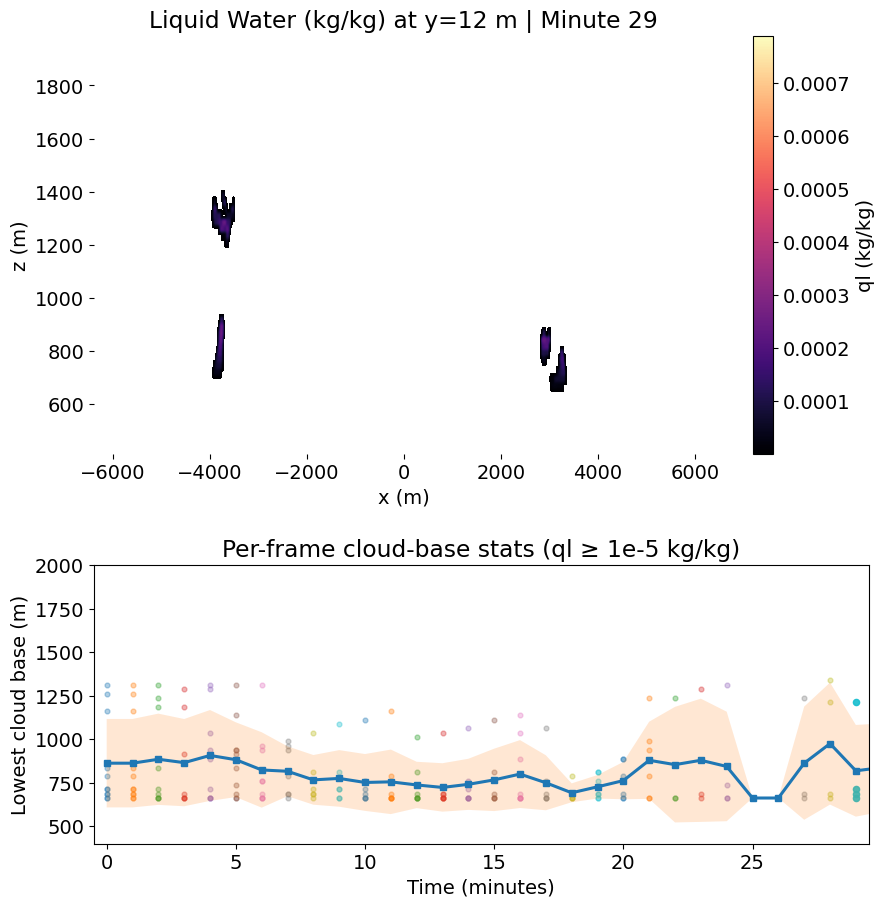

In [ ]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.ndimage import label

# ------------------ USER PARAMETERS ------------------
L_FILE        = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
VAR_NAME      = 'l'            # variable name in file (kg/kg)
THRESH        = 1e-7           # kg/kg
Z_MIN, Z_MAX  = 400.0, 2000.0  # m
NUM_MINUTES   = 3             # number of timesteps to animate
Y_SLICE_MODE  = 'middle'       # or give an int index
FPS           = 2
OUTPUT        = 'liq_water_side_on.mp4'
# -----------------------------------------------------

# Save transparently
plt.rcParams['savefig.facecolor'] = 'none'
plt.rcParams['savefig.edgecolor'] = 'none'


def load_vertical_slice(ds, var_name, t, y_idx):
    """Return slice (z,x) in original units (kg/kg) and coordinates."""
    sl = ds[var_name][t, :, y_idx, :]  # kg/kg
    return sl, ds['xt'][:], ds['zt'][:]

# ----------------- PRECOMPUTE -----------------
with nc.Dataset(L_FILE) as ds:
    yt = ds['yt'][:]
    y_slice_idx = len(yt)//2 if Y_SLICE_MODE == 'middle' else int(Y_SLICE_MODE)
    y_coord = yt[y_slice_idx]

    max_t = ds[VAR_NAME].shape[0]
    n_frames = min(NUM_MINUTES, max_t)

    vmin, vmax = np.inf, -np.inf
    for t in range(n_frames):
        sl, _, zt = load_vertical_slice(ds, VAR_NAME, t, y_slice_idx)
        zmask = (zt >= Z_MIN) & (zt <= Z_MAX)
        sl = sl[zmask, :]
        if sl.size:
            vmin = min(vmin, sl.min())
            vmax = max(vmax, sl.max())

# Anything below THRESH will render white
display_vmin = THRESH
vmin = min(vmin, display_vmin)

# ----------------- FIGURE -----------------
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, figsize=(10, 10.5),
    gridspec_kw={'height_ratios':[3, 2], 'hspace':0.32}
)

fig.patch.set_alpha(0.0)
ax_top.set_facecolor('none')   # transparent top axes
ax_bot.set_facecolor('white')

# Different colourmap & white for under-threshold
cmap = plt.get_cmap('magma').copy()
cmap.set_under('white')

# Storage for cumulative points & stats
lowest_per_frame = []          # list of arrays of lowest z for each frame
means = []
vars_ = []

def lowest_points_per_cloud(slice_field, z_vec):
    """Connected components in x–z; return min z of each component."""
    mask = slice_field >= THRESH
    if not mask.any():
        return np.array([])
    lbl, nlab = label(mask)  # 8-neighbour connectivity
    lows = []
    for lab_id in range(1, nlab+1):
        region = (lbl == lab_id)
        if region.any():
            lowest_row = np.where(region)[0].min()
            lows.append(z_vec[lowest_row])
    return np.array(lows)

def update(frame):
    ax_top.clear()
    ax_bot.clear()

    with nc.Dataset(L_FILE) as ds:
        sl, xt, zt = load_vertical_slice(ds, VAR_NAME, frame, y_slice_idx)

    # z trimming
    zmask  = (zt >= Z_MIN) & (zt <= Z_MAX)
    sl     = sl[zmask, :]
    zt_cut = zt[zmask]

    # --- TOP PLOT ---
    im = ax_top.imshow(
        sl,
        cmap=cmap,
        origin='lower',
        vmin=display_vmin, vmax=vmax,
        extent=[xt.min(), xt.max(), zt_cut.min(), zt_cut.max()],
        aspect='auto'
    )
    ax_top.set_title(f'Liquid Water (kg/kg) at y={y_coord:.0f} m | Minute {frame}')
    ax_top.set_xlabel('x (m)')
    ax_top.set_ylabel('z (m)')
    ax_top.set_facecolor('none')
    for spine in ax_top.spines.values():
        spine.set_visible(False)

    # --- BOTTOM PLOT ---
    lows = lowest_points_per_cloud(sl, zt_cut)
    lowest_per_frame.append(lows)

    # Scatter all points (past faint, current solid)
    for t_prev, arr in enumerate(lowest_per_frame):
        if arr.size == 0:
            continue
        ax_bot.scatter(
            np.full_like(arr, t_prev), arr,
            s=20 if t_prev == frame else 12,
            alpha=0.9 if t_prev == frame else 0.35
        )

    # Recompute stats up to each frame and plot persistent mean ±1σ band
    means.clear(); vars_.clear()
    for arr in lowest_per_frame:
        if arr.size:
            m = arr.mean()
            v = arr.var(ddof=1) if arr.size > 1 else 0.0
        else:
            m = np.nan; v = np.nan
        means.append(m); vars_.append(v)

    frames_so_far = np.arange(len(lowest_per_frame))
    means_np = np.array(means)
    stds_np  = np.sqrt(np.array(vars_))

    # Mean as thick line
    ax_bot.plot(frames_so_far, means_np, linewidth=2.2, linestyle='-', marker='s', markersize=5)

    # ±1σ band
    valid = ~np.isnan(means_np) & ~np.isnan(stds_np)
    if valid.any():
        ax_bot.fill_between(frames_so_far[valid],
                            (means_np - stds_np)[valid],
                            (means_np + stds_np)[valid],
                            alpha=0.18)

    ax_bot.set_xlim(-0.5, n_frames-0.5)
    ax_bot.set_ylim(Z_MIN, Z_MAX)
    ax_bot.set_xlabel('Time (minutes)')
    ax_bot.set_ylabel('Lowest cloud base (m)')
    ax_bot.set_title('Per-frame cloud-base stats (ql ≥ 1e-5 kg/kg)')

    return [im]

# Stable colorbar
dummy = ax_top.imshow(np.zeros((2,2)), cmap=cmap, vmin=display_vmin, vmax=vmax)
fig.colorbar(dummy, ax=ax_top, orientation='vertical', label='ql (kg/kg)')

ani = FuncAnimation(fig, update, frames=n_frames, blit=False)

ani.save(
    OUTPUT,
    writer='ffmpeg',
    fps=FPS,
    dpi=150,
    savefig_kwargs={'transparent': True}
)

plt.show()


# Another plot (below 800m only)

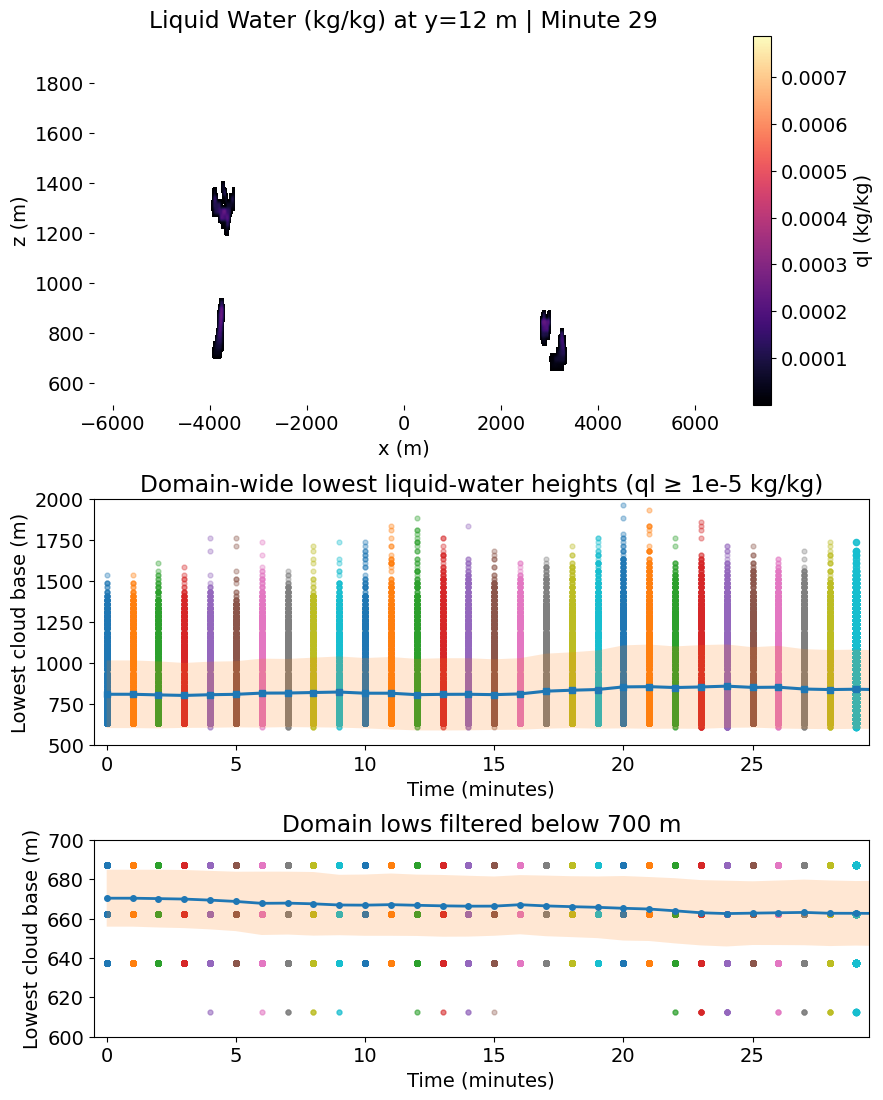

In [ ]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.ndimage import label

"""
Bottom panel now uses the ENTIRE DOMAIN (all y) to compute lowest liquid-water points per cloud.
A third panel below that shows ONLY those lowest points < 800 m.
Top slice panel remains unchanged (single y-slice visualised).
Units remain kg/kg.
"""

# ------------------ USER PARAMETERS ------------------
L_FILE        = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
VAR_NAME      = 'l'            # kg/kg
THRESH        = 1e-7           # kg/kg threshold for liquid water
Z_MIN, Z_MAX  = 500.0, 2000.0  # m range to display in top plot
NUM_MINUTES   = 3             # timesteps to animate
Y_SLICE_MODE  = 'middle'       # which y-index to visualise on top plot
FPS           = 2
OUTPUT        = 'liq_water_side_on.mp4'
SUBSET_CUTOFF = 700.0          # m, for third (subset) panel
# -----------------------------------------------------

plt.rcParams['savefig.facecolor'] = 'none'
plt.rcParams['savefig.edgecolor'] = 'none'

# ----------------- HELPERS -----------------
def load_vertical_slice(ds, var_name, t, y_idx):
    sl = ds[var_name][t, :, y_idx, :]            # (z,x) kg/kg
    return sl, ds['xt'][:], ds['zt'][:]

def lowest_points_per_cloud_2d(slice_field, z_vec, thresh):
    """Connected components in a 2D (z,x) mask; return min z for each blob."""
    mask = slice_field >= thresh
    if not mask.any():
        return np.array([])
    lbl, nlab = label(mask)  # 8-connectivity in 2D
    lows = []
    for lab_id in range(1, nlab + 1):
        region = (lbl == lab_id)
        if region.any():
            lowest_row = np.where(region)[0].min()
            lows.append(z_vec[lowest_row])
    return np.array(lows)

def lowest_points_entire_domain(ds, var_name, t, thresh):
    """
    Compute lowest z of each cloud using the WHOLE domain (y,x plane).
    Strategy: treat each y-slice independently (2D in z-x) and pool the minima.
    (Full 3D connectivity would be pricier; clarify if you need that.)
    Returns array of lowest heights across all clouds in all y-slices.
    """
    zt = ds['zt'][:]
    yt = ds['yt'][:]
    lows_all = []
    for y_idx in range(len(yt)):
        sl = ds[var_name][t, :, y_idx, :]  # (z,x)
        lows = lowest_points_per_cloud_2d(sl, zt, thresh)
        if lows.size:
            lows_all.append(lows)
    if lows_all:
        return np.concatenate(lows_all)
    return np.array([])

# ----------------- PRECOMPUTE LIMITS -----------------
with nc.Dataset(L_FILE) as ds:
    yt = ds['yt'][:]
    y_slice_idx = len(yt)//2 if Y_SLICE_MODE == 'middle' else int(Y_SLICE_MODE)
    y_coord = yt[y_slice_idx]

    max_t = ds[VAR_NAME].shape[0]
    n_frames = min(NUM_MINUTES, max_t)

    vmin, vmax = np.inf, -np.inf
    for t in range(n_frames):
        sl, _, zt = load_vertical_slice(ds, VAR_NAME, t, y_slice_idx)
        zmask = (zt >= Z_MIN) & (zt <= Z_MAX)
        sl = sl[zmask, :]
        if sl.size:
            vmin = min(vmin, sl.min())
            vmax = max(vmax, sl.max())

DISPLAY_VMIN = THRESH
vmin = min(vmin, DISPLAY_VMIN)

# ----------------- FIGURE / AXES -----------------
fig, (ax_top, ax_mid, ax_bot) = plt.subplots(
    3, 1, figsize=(10, 13),
    gridspec_kw={'height_ratios': [3, 2, 1.6], 'hspace': 0.35}
)

fig.patch.set_alpha(0.0)
ax_top.set_facecolor('none')   # transparent
ax_mid.set_facecolor('white')
ax_bot.set_facecolor('white')

# colourmap for top
cmap = plt.get_cmap('magma').copy()
cmap.set_under('white')

# Storage structures
slice_lowest_all_frames   = []  # from single y-slice (for completeness, we still scatter these?)
domain_lowest_all_frames  = []  # ENTIRE domain per frame
subset_lowest_all_frames  = []  # domain lows filtered < SUBSET_CUTOFF

means_domain = []
vars_domain  = []
means_subset = []
vars_subset  = []

def update(frame):
    ax_top.clear(); ax_mid.clear(); ax_bot.clear()

    with nc.Dataset(L_FILE) as ds:
        # --- TOP SLICE ---
        sl, xt, zt = load_vertical_slice(ds, VAR_NAME, frame, y_slice_idx)
        zmask = (zt >= Z_MIN) & (zt <= Z_MAX)
        sl_cut = sl[zmask, :]
        zt_cut = zt[zmask]

        im = ax_top.imshow(
            sl_cut,
            cmap=cmap,
            origin='lower',
            vmin=DISPLAY_VMIN, vmax=vmax,
            extent=[xt.min(), xt.max(), zt_cut.min(), zt_cut.max()],
            aspect='auto'
        )
        ax_top.set_title(f'Liquid Water (kg/kg) at y={y_coord:.0f} m | Minute {frame}')
        ax_top.set_xlabel('x (m)')
        ax_top.set_ylabel('z (m)')
        ax_top.set_facecolor('none')
        for s in ax_top.spines.values():
            s.set_visible(False)

        # --- DOMAIN-LEVEL LOWEST POINTS ---
        lows_domain = lowest_points_entire_domain(ds, VAR_NAME, frame, THRESH)
        domain_lowest_all_frames.append(lows_domain)

        # subset < 800 m
        lows_subset = lows_domain[lows_domain < SUBSET_CUTOFF]
        subset_lowest_all_frames.append(lows_subset)

    # -------- MID PANEL: full-domain stats --------
    # scatter all points
    for t_prev, arr in enumerate(domain_lowest_all_frames):
        if arr.size == 0:
            continue
        ax_mid.scatter(
            np.full_like(arr, t_prev), arr,
            s=20 if t_prev == frame else 12,
            alpha=0.9 if t_prev == frame else 0.35
        )

    # recompute means/vars for domain
    means_domain.clear(); vars_domain.clear()
    for arr in domain_lowest_all_frames:
        if arr.size:
            m = arr.mean(); v = arr.var(ddof=1) if arr.size > 1 else 0.0
        else:
            m = np.nan; v = np.nan
        means_domain.append(m); vars_domain.append(v)

    frames_so_far = np.arange(len(domain_lowest_all_frames))
    means_dom_np = np.array(means_domain)
    std_dom_np   = np.sqrt(np.array(vars_domain))

    # mean line + band
    ax_mid.plot(frames_so_far, means_dom_np, linewidth=2.2, linestyle='-', marker='s', markersize=5)
    valid = ~np.isnan(means_dom_np) & ~np.isnan(std_dom_np)
    if valid.any():
        ax_mid.fill_between(frames_so_far[valid],
                            (means_dom_np - std_dom_np)[valid],
                            (means_dom_np + std_dom_np)[valid],
                            alpha=0.18)

    ax_mid.set_xlim(-0.5, n_frames - 0.5)
    ax_mid.set_ylim(Z_MIN, Z_MAX)
    ax_mid.set_xlabel('Time (minutes)')
    ax_mid.set_ylabel('Lowest cloud base (m)')
    ax_mid.set_title('Domain-wide lowest liquid-water heights (ql ≥ 1e-5 kg/kg)')

    # -------- BOT PANEL: subset < 800 m --------
    for t_prev, arr in enumerate(subset_lowest_all_frames):
        if arr.size == 0:
            continue
        ax_bot.scatter(
            np.full_like(arr, t_prev), arr,
            s=20 if t_prev == frame else 12,
            alpha=0.9 if t_prev == frame else 0.35
        )

    means_subset.clear(); vars_subset.clear()
    for arr in subset_lowest_all_frames:
        if arr.size:
            m = arr.mean(); v = arr.var(ddof=1) if arr.size > 1 else 0.0
        else:
            m = np.nan; v = np.nan
        means_subset.append(m); vars_subset.append(v)

    means_sub_np = np.array(means_subset)
    std_sub_np   = np.sqrt(np.array(vars_subset))

    ax_bot.plot(frames_so_far, means_sub_np, linewidth=2.0, linestyle='-', marker='o', markersize=4)
    valid2 = ~np.isnan(means_sub_np) & ~np.isnan(std_sub_np)
    if valid2.any():
        ax_bot.fill_between(frames_so_far[valid2],
                            (means_sub_np - std_sub_np)[valid2],
                            (means_sub_np + std_sub_np)[valid2],
                            alpha=0.18)

    ax_bot.set_xlim(-0.5, n_frames - 0.5)
    ax_bot.set_ylim(600.0, 700.0)
    ax_bot.set_xlabel('Time (minutes)')
    ax_bot.set_ylabel('Lowest cloud base (m)')
    ax_bot.set_title(f'Domain lows filtered below {SUBSET_CUTOFF:.0f} m')

    return [im]

# Colorbar for top
_dummy = ax_top.imshow(np.zeros((2, 2)), cmap=cmap, vmin=DISPLAY_VMIN, vmax=vmax)
fig.colorbar(_dummy, ax=ax_top, orientation='vertical', label='ql (kg/kg)')

ani = FuncAnimation(fig, update, frames=n_frames, blit=False)

ani.save(
    OUTPUT,
    writer='ffmpeg',
    fps=FPS,
    dpi=150,
    savefig_kwargs={'transparent': True}
)

plt.show()


# Threshold sensitivity: liquid water

Exploring how sensitive certain characteristics of the cloud field are to the liquid water threshold. 

Loading data for timestep 0...
Loading data for timestep 1...


Processing cloud sizes: 100%|██████████| 2/2 [00:18<00:00,  9.12s/it]



Analysis complete. Summary:
- Timesteps analyzed: 2
- Thresholds tested: 25
- Total records: 50

Average cloud counts by threshold:
  Threshold 1.00e-07: 295.0 clouds
  Threshold 1.33e-07: 294.5 clouds
  Threshold 1.78e-07: 293.5 clouds
  Threshold 2.37e-07: 294.0 clouds
  Threshold 3.16e-07: 294.0 clouds
  Threshold 4.22e-07: 293.5 clouds
  Threshold 5.62e-07: 293.5 clouds
  Threshold 7.50e-07: 293.5 clouds
  Threshold 1.00e-06: 292.5 clouds
  Threshold 1.33e-06: 292.0 clouds
  Threshold 1.78e-06: 291.5 clouds
  Threshold 2.37e-06: 290.0 clouds
  Threshold 3.16e-06: 291.0 clouds
  Threshold 4.22e-06: 291.0 clouds
  Threshold 5.62e-06: 287.0 clouds
  Threshold 7.50e-06: 287.0 clouds
  Threshold 1.00e-05: 283.5 clouds
  Threshold 1.33e-05: 289.0 clouds
  Threshold 1.78e-05: 286.0 clouds
  Threshold 2.37e-05: 284.0 clouds
  Threshold 3.16e-05: 284.5 clouds
  Threshold 4.22e-05: 270.5 clouds
  Threshold 5.62e-05: 266.5 clouds
  Threshold 7.50e-05: 247.5 clouds
  Threshold 1.00e-04: 233.5

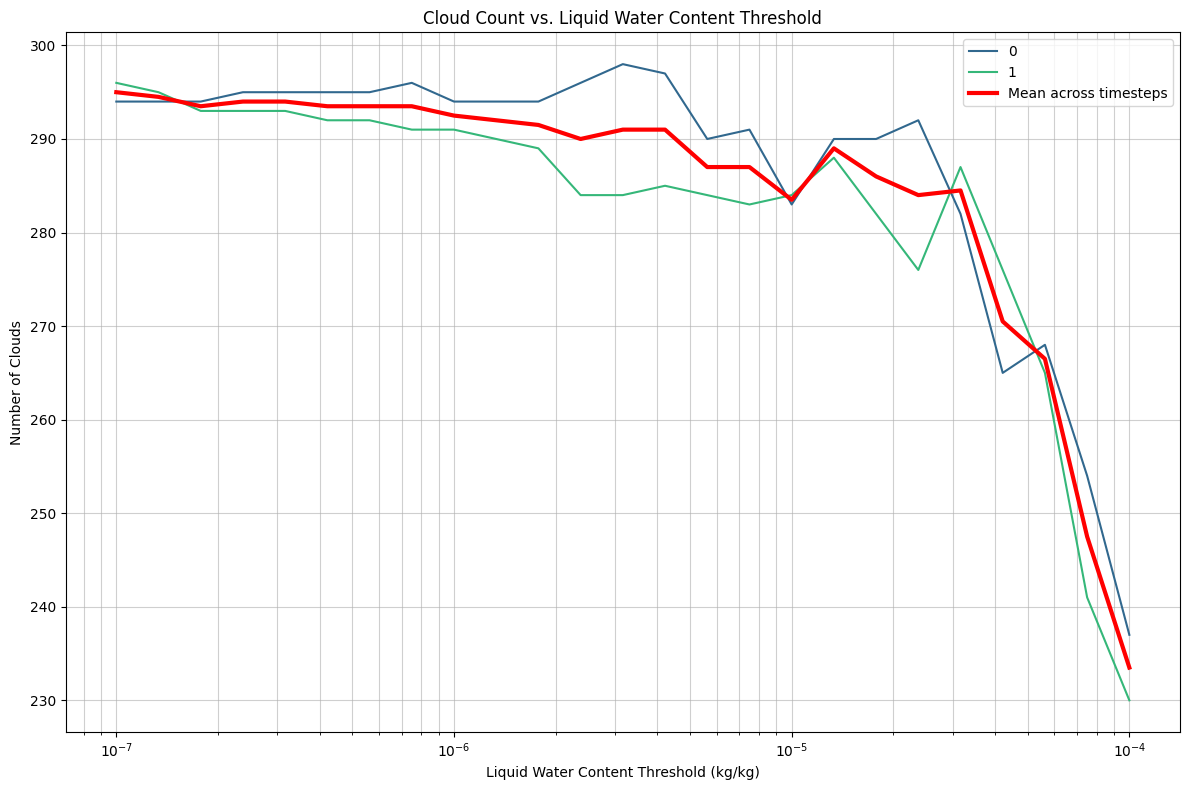

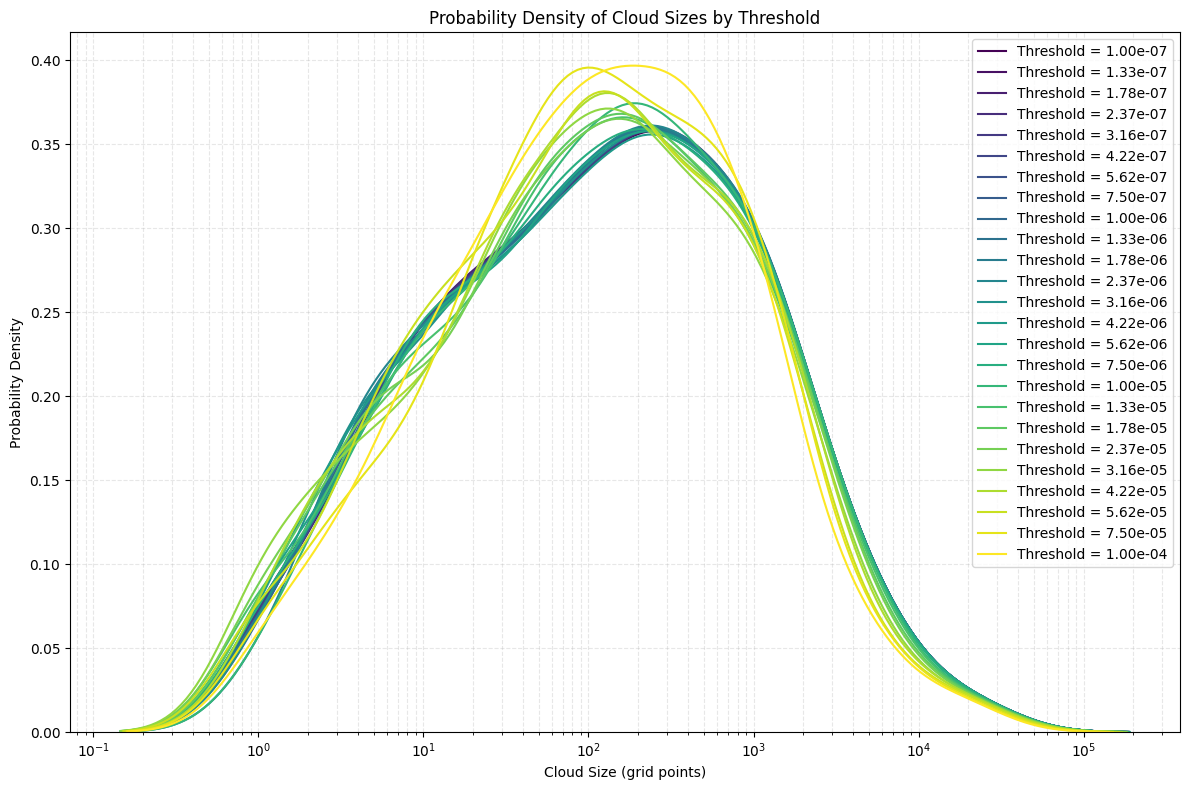

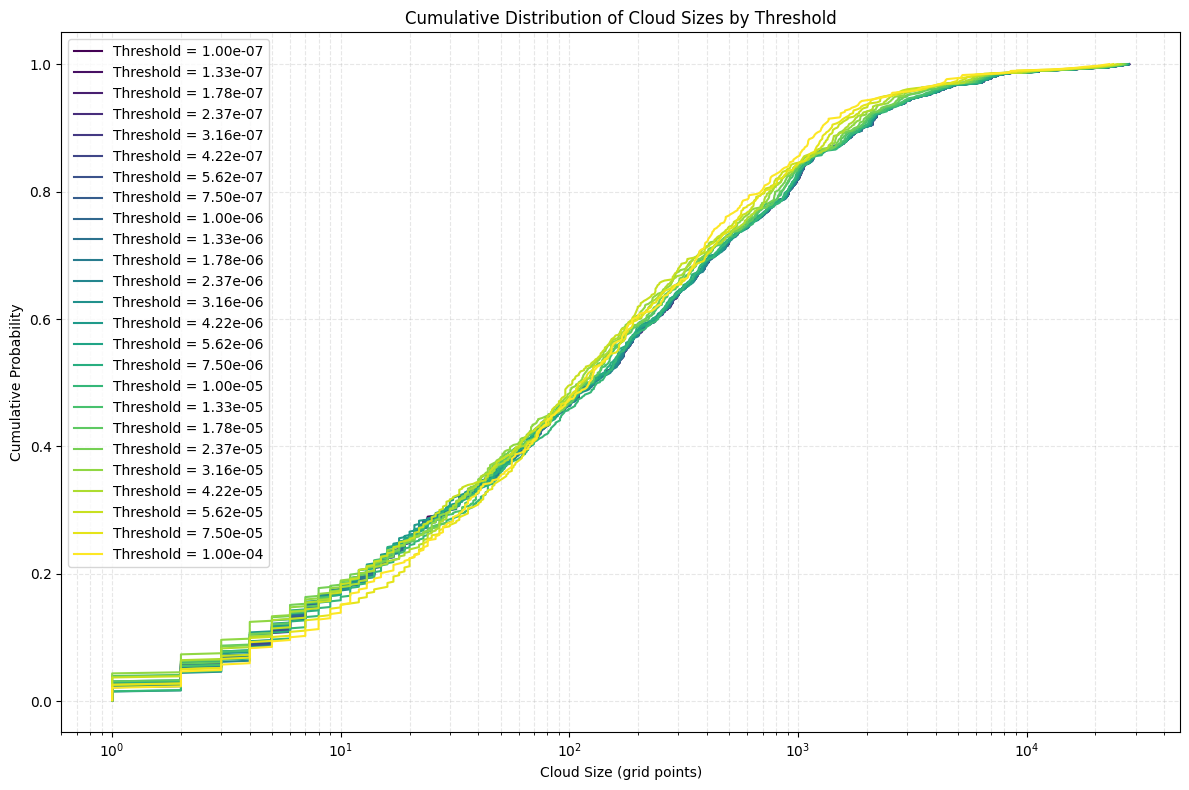

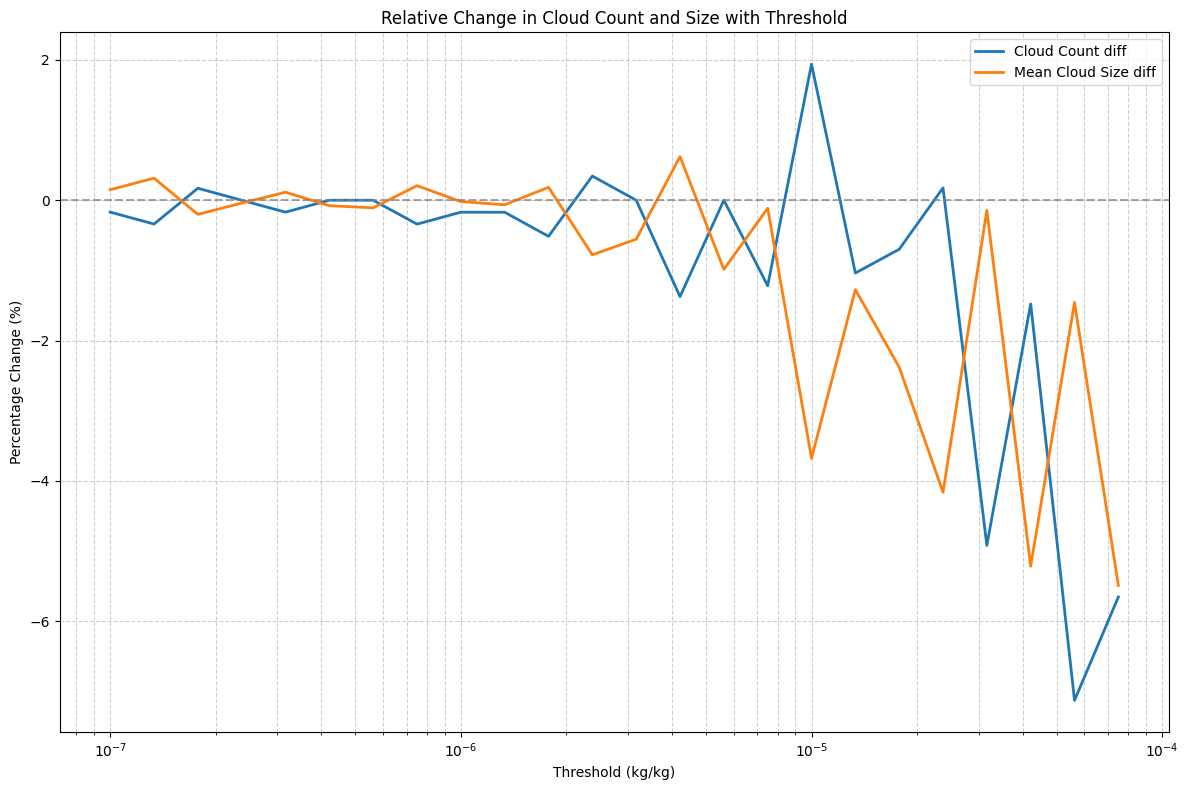

In [33]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from skimage import measure
from tqdm import tqdm
import pandas as pd
import seaborn as sns

def load_data_for_timestep(file_path, file_names, timestep):
    """
    Load cloud data from files for a specific timestep.
    """
    print(f"Loading data for timestep {timestep}...")
    
    # Load grid coordinates first
    with Dataset(f"{file_path}{file_names['l']}", 'r') as l_dataset:
        xt = l_dataset.variables['xt'][:]
        yt = l_dataset.variables['yt'][:]
        zt = l_dataset.variables['zt'][:]
    
    # Load liquid water content
    with Dataset(f"{file_path}{file_names['l']}", 'r') as dataset:
        l_data = dataset.variables['l'][timestep, :, :, :]
    
    return {
        'l_data': l_data,
        'xt': xt,
        'yt': yt,
        'zt': zt,
        'timestep': timestep
    }

def identify_clouds(l_data, l_condition):
    """
    Identify cloud regions based on liquid water content threshold.
    """
    # Create condition based on threshold
    condition = l_data > l_condition
    
    # Label the regions with 3D connectivity
    labeled_array = measure.label(condition, connectivity=3)
    
    # Count regions
    unique_labels = np.unique(labeled_array)
    num_clouds = len(unique_labels) - 1  # Subtract 1 for background
    
    return num_clouds

def analyze_cloud_counts_vs_threshold(data_list, thresholds):
    """
    Analyze how cloud count varies with liquid water content threshold.
    """
    results = []
    
    # Process each timestep
    for data in tqdm(data_list, desc="Processing timesteps"):
        timestep = data['timestep']
        l_data = data['l_data']
        
        # Try each threshold
        for threshold in tqdm(thresholds, desc=f"Testing thresholds for timestep {timestep}", leave=False):
            num_clouds = identify_clouds(l_data, threshold)
            
            results.append({
                'threshold': threshold,
                'timestep': timestep,
                'cloud_count': num_clouds
            })
    
    return pd.DataFrame(results)

def plot_cloud_counts(results_df, title=None, figsize=(12, 8)):
    """
    Plot cloud count vs threshold.
    """
    plt.figure(figsize=figsize)
    
    # Plot individual timesteps
    sns.lineplot(
        data=results_df,
        x='threshold',
        y='cloud_count',
        hue='timestep',
        palette='viridis'
    )
    
    # Plot mean across timesteps
    mean_df = results_df.groupby('threshold')['cloud_count'].mean().reset_index()
    sns.lineplot(
        data=mean_df,
        x='threshold',
        y='cloud_count',
        color='red',
        linewidth=3,
        label='Mean across timesteps'
    )
    
    plt.xscale('log')
    plt.grid(True, which="both", linestyle="-", alpha=0.6)
    plt.xlabel('Liquid Water Content Threshold (kg/kg)')
    plt.ylabel('Number of Clouds')
    plt.title(title or 'Cloud Count vs. Liquid Water Content Threshold')
    plt.tight_layout()
    
    return plt.gcf()

def identify_clouds_with_sizes(l_data, l_condition):
    """
    Identify cloud regions based on liquid water content threshold.
    Returns array of cloud sizes in grid points.
    """
    # Create condition based on threshold
    condition = l_data > l_condition
    
    # Label the regions with 3D connectivity
    labeled_array = measure.label(condition, connectivity=3)
    
    # Get region properties to extract sizes
    regions = measure.regionprops(labeled_array)
    cloud_sizes = [region.area for region in regions]
    
    return np.array(cloud_sizes)

def analyze_cloud_size_distributions(data_list, thresholds):
    """
    Analyze cloud size distributions for different thresholds.
    """
    all_distributions = {}
    
    # Process each threshold
    for threshold in thresholds:
        all_distributions[threshold] = []
    
    # Process each timestep
    for data in tqdm(data_list, desc="Processing cloud sizes"):
        timestep = data['timestep']
        l_data = data['l_data']
        
        # Try each threshold
        for threshold in tqdm(thresholds, desc=f"Threshold analysis for timestep {timestep}", leave=False):
            cloud_sizes = identify_clouds_with_sizes(l_data, threshold)
            
            # Store sizes for this timestep and threshold
            all_distributions[threshold].extend(cloud_sizes.tolist())
    
    return all_distributions

def plot_cloud_size_pdf(distributions, thresholds, figsize=(12, 8)):
    """
    Plot probability density function of cloud sizes for each threshold.
    """
    plt.figure(figsize=figsize)
    
    # Define color palette based on number of thresholds
    colors = plt.cm.viridis(np.linspace(0, 1, len(thresholds)))
    
    # Plot PDF for each threshold
    for i, threshold in enumerate(sorted(thresholds)):
        sizes = distributions[threshold]
        if not sizes:  # Skip if no clouds were found
            continue
            
        # Use KDE (Kernel Density Estimation) to get smooth PDF
        sns.kdeplot(
            sizes, 
            label=f'Threshold = {threshold:.2e}',
            color=colors[i],
            log_scale=True  # Use log scale for sizes since they can vary by orders of magnitude
        )
    
    plt.xlabel('Cloud Size (grid points)')
    plt.ylabel('Probability Density')
    plt.title('Probability Density of Cloud Sizes by Threshold')
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()



def plot_cloud_size_cdf(distributions, thresholds, figsize=(12, 8)):
    """
    Plot cumulative distribution function of cloud sizes for each threshold.
    """
    plt.figure(figsize=figsize)
    
    # Define color palette based on number of thresholds
    colors = plt.cm.viridis(np.linspace(0, 1, len(thresholds)))
    
    # Plot CDF for each threshold
    for i, threshold in enumerate(sorted(thresholds)):
        sizes = distributions[threshold]
        if not sizes:  # Skip if no clouds were found
            continue
            
        # Sort sizes for CDF calculation
        sorted_sizes = np.sort(sizes)
        # Calculate CDF (y value is fraction of data points <= x)
        y = np.arange(1, len(sorted_sizes) + 1) / len(sorted_sizes)
        
        # Plot the CDF
        plt.plot(
            sorted_sizes, y,
            label=f'Threshold = {threshold:.2e}',
            color=colors[i]
        )
    
    plt.xscale('log')  # Use log scale for sizes since they can vary by orders of magnitude
    plt.xlabel('Cloud Size (grid points)')
    plt.ylabel('Cumulative Probability')
    plt.title('Cumulative Distribution of Cloud Sizes by Threshold')
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()


def plot_fractional_differences(results_df, cloud_size_distributions, thresholds, figsize=(12, 8)):
    """
    Plot fractional differences as percentages for cloud count and mean cloud size as thresholds increase.
    Formula: 100 * (N(θᵢ₊₁) − N(θᵢ)) / N(θᵢ)
    """
    plt.figure(figsize=figsize)
    sorted_thresholds = sorted(thresholds)

    # 1. Cloud count fractional differences
    mean_counts = results_df.groupby('threshold')['cloud_count'].mean()
    count_diffs = []
    count_x = []
    for i in range(len(sorted_thresholds) - 1):
        t0, t1 = sorted_thresholds[i], sorted_thresholds[i + 1]
        n0, n1 = mean_counts.get(t0, np.nan), mean_counts.get(t1, np.nan)
        if n0 > 0:
            # Convert to percentage by multiplying by 100
            count_diffs.append(100 * (n1 - n0) / n0)
            count_x.append(t0)

    # 2. Mean cloud size fractional differences
    size_means = [
        (t, np.mean(cloud_size_distributions[t]))
        for t in sorted_thresholds if len(cloud_size_distributions.get(t, []))
    ]
    size_diffs = []
    size_x = []
    for i in range(len(size_means) - 1):
        t0, s0 = size_means[i]
        t1, s1 = size_means[i + 1]
        if s0 > 0:
            # Convert to percentage by multiplying by 100
            size_diffs.append(100 * (s1 - s0) / s0)
            size_x.append(t0)

    # Plotting
    plt.plot(count_x, count_diffs, '-', label='Cloud Count diff', linewidth=2)
    plt.plot(size_x, size_diffs, '-', label='Mean Cloud Size diff', linewidth=2)

    plt.xscale('log')
    plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.xlabel('Threshold (kg/kg)')
    plt.ylabel('Percentage Change (%)')  # Updated y-axis label
    plt.title('Relative Change in Cloud Count and Size with Threshold')
    plt.legend()
    plt.tight_layout()

    return plt.gcf()


# ----- Main Analysis Code -----

# Configuration
base_file_path = '/Users/jure/PhD/coding/RICO_1hr/' 
file_names = {
    'l': 'rico.l.nc',  # Liquid water file
}

# Analysis parameters
timesteps_to_analyze = [0,1]  # 30 steps
#thresholds = [1e-6, 1e-5, 1e-4]
thresholds = np.logspace(-7, -4, num=25)

# Load data for all timesteps
data_list = []
for timestep in timesteps_to_analyze:
    data = load_data_for_timestep(base_file_path, file_names, timestep)
    data_list.append(data)

# Analyze cloud counts for different thresholds
results = analyze_cloud_counts_vs_threshold(
    data_list, 
    thresholds
)

# Plot the cloud count results
fig = plot_cloud_counts(
    results,
    title='Cloud Count vs. Liquid Water Content Threshold'
)

# Now analyze cloud size distributions using the same thresholds
cloud_size_distributions = analyze_cloud_size_distributions(
    data_list, 
    thresholds
)

# Plot the cloud size PDF
size_pdf_fig = plot_cloud_size_pdf(
    cloud_size_distributions,
    thresholds,
    figsize=(12, 8)
)

size_cdf_fig = plot_cloud_size_cdf(
    cloud_size_distributions,
    thresholds,
    figsize=(12, 8)
)

fractional_diff_fig = plot_fractional_differences(
    results,
    cloud_size_distributions,
    thresholds,
    figsize=(12, 8)
)

# Print summary statistics
print(f"\nAnalysis complete. Summary:")
print(f"- Timesteps analyzed: {len(timesteps_to_analyze)}")
print(f"- Thresholds tested: {len(thresholds)}")
print(f"- Total records: {len(results)}")

# Show average cloud counts for each threshold
print("\nAverage cloud counts by threshold:")
mean_counts = results.groupby('threshold')['cloud_count'].mean().reset_index()
for _, row in mean_counts.iterrows():
    print(f"  Threshold {row['threshold']:.2e}: {row['cloud_count']:.1f} clouds")

# Display the size statistics for each threshold
print("\nCloud size statistics by threshold:")
for threshold in sorted(thresholds):
    sizes = cloud_size_distributions[threshold]
    if sizes:
        print(f"  Threshold {threshold:.2e}: {len(sizes)} clouds, " +
              f"Mean size: {np.mean(sizes):.1f}, " +
              f"Min: {np.min(sizes)}, " +
              f"Max: {np.max(sizes)}")
    else:
        print(f"  Threshold {threshold:.2e}: No clouds detected")

plt.show()

Threshold sweep: 100%|██████████| 21/21 [04:32<00:00, 13.00s/it]


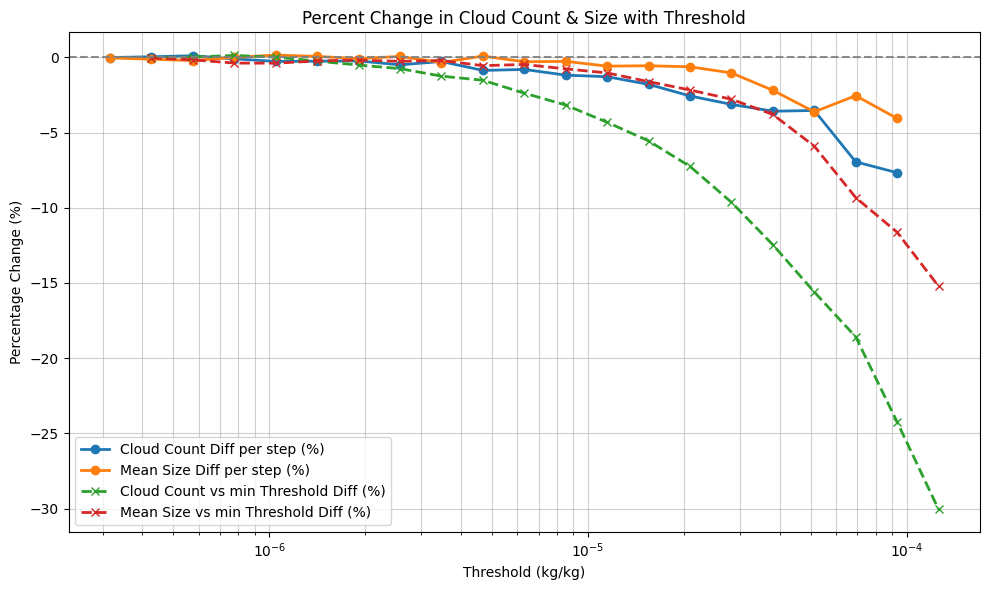

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from skimage import measure
from tqdm import tqdm

# --- Minimal helpers ---

def load_lwc(file_path, filename, timestep):
    """Load a single timestep of liquid‐water content."""
    with Dataset(f"{file_path}{filename}", 'r') as ds:
        return ds.variables['l'][timestep, ...]  # (z,y,x) array

def count_clouds(l_data, θ):
    """Count 3D-connected cloud regions above θ."""
    mask = l_data > θ
    labels = measure.label(mask, connectivity=3)
    return labels.max()

def mean_cloud_size(l_data, θ):
    """Compute mean voxel-count per cloud above θ."""
    mask = l_data > θ
    labels = measure.label(mask, connectivity=3)
    props = measure.regionprops(labels)
    if not props:
        return 0.0
    sizes = [p.area for p in props]
    return np.mean(sizes)

# --- Main routine ---

# Configuration
base_path  = '/Users/jure/PhD/coding/RICO_1hr/'
l_file     = 'rico.l.nc'
timesteps  = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]  # 20 timesteps
thresholds = np.logspace(-6.5, -3.9, 21)

# 1) Load all timesteps once
l_data_list = [load_lwc(base_path, l_file, t) for t in timesteps]

# 2) Compute mean counts & sizes
mean_counts = []
mean_sizes  = []
for θ in tqdm(thresholds, desc="Threshold sweep"):
    counts = [count_clouds(ld, θ) for ld in l_data_list]
    sizes  = [mean_cloud_size(ld, θ) for ld in l_data_list]
    mean_counts.append(np.mean(counts))
    mean_sizes.append(np.mean(sizes))

# 3a) Compute *stepwise* percentage differences between consecutive thresholds
pct_count_diffs = []
pct_size_diffs  = []
x_vals          = thresholds[:-1]
for i in range(len(thresholds)-1):
    n0, n1 = mean_counts[i], mean_counts[i+1]
    s0, s1 = mean_sizes[i],  mean_sizes[i+1]
    pct_count_diffs.append(100 * (n1 - n0) / n0 if n0>0 else np.nan)
    pct_size_diffs .append(100 * (s1 - s0) / s0 if s0>0 else np.nan)

# 3b) Compute percentage differences relative to the smallest threshold θ₀
baseline_count = mean_counts[0]
baseline_size  = mean_sizes[0]

pct_count_from_min = [
    100 * (mean_counts[i] - baseline_count) / baseline_count
    for i in range(1, len(mean_counts))
]
pct_size_from_min = [
    100 * (mean_sizes[i] - baseline_size) / baseline_size
    for i in range(1, len(mean_sizes))
]
x_from_min = thresholds[1:]

# 4) Plot everything
plt.figure(figsize=(10, 6))

# stepwise diffs
plt.plot(
    x_vals, pct_count_diffs, 'o-', 
    label='Cloud Count Diff per step (%)', linewidth=2
)
plt.plot(
    x_vals, pct_size_diffs, 'o-', 
    label='Mean Size Diff per step (%)', linewidth=2
)

# diffs from smallest θ
plt.plot(
    x_from_min, pct_count_from_min, 'x--', 
    label='Cloud Count vs min Threshold Diff (%)', linewidth=2
)
plt.plot(
    x_from_min, pct_size_from_min, 'x--', 
    label='Mean Size vs min Threshold Diff (%)', linewidth=2
)

plt.xscale('log')
plt.axhline(0, color='gray', linestyle='--', alpha=0.9)
plt.grid(True, which='both', linestyle='-', alpha=0.6)
plt.xlabel('Threshold (kg/kg)')
plt.ylabel('Percentage Change (%)')
plt.title('Percent Change in Cloud Count & Size with Threshold')
plt.legend()
plt.tight_layout()
plt.show()


Min (non-zero):         2.76e-10 kg/kg
1st percentile (non-0): 1.83e-06 kg/kg
99th percentile:        1.10e-03 kg/kg
Max:                    1.87e-03 kg/kg


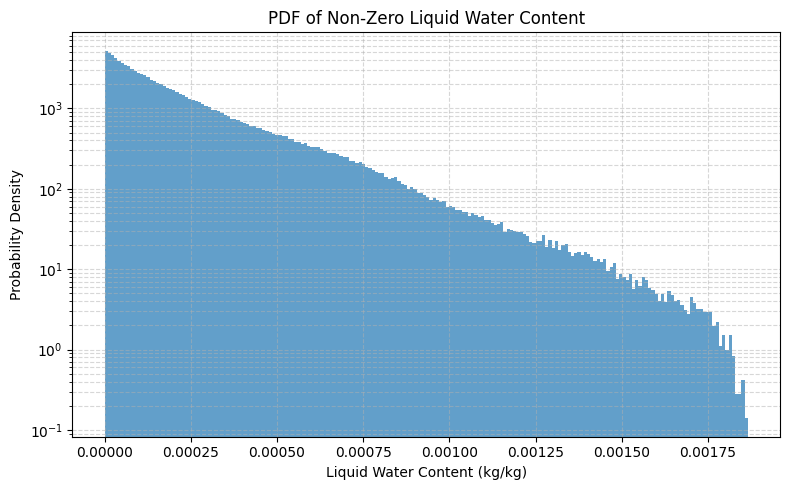

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

# --- Load all LWC data into one big array, excluding zeros ---
def load_nonzero_lwc(file_path, filename, timesteps):
    all_vals = []
    with Dataset(f"{file_path}{filename}", 'r') as ds:
        for t in timesteps:
            lw = ds.variables['l'][t, ...].ravel()
            # keep only positive values
            all_vals.append(lw[lw > 0])
    return np.concatenate(all_vals)

# Configuration
# base_path = '/Users/jure/PhD/coding/RICO_1hr/'
# l_file    = 'rico.l.nc'

base_path = '/Users/jure/Downloads/rico_data'
l_file    = 'rico_4min.l.nc'

timesteps = [0,1,2]   # adjust as needed

# Load & flatten non-zero points
all_lwc_nz = load_nonzero_lwc(base_path, l_file, timesteps)

# --- Compute summary stats on non-zero data ---
min_val    = np.min(all_lwc_nz)
max_val    = np.max(all_lwc_nz)
pct1_low   = np.percentile(all_lwc_nz, 1)
pct99_high = np.percentile(all_lwc_nz, 99)

print(f"Min (non-zero):         {min_val:.2e} kg/kg")
print(f"1st percentile (non-0): {pct1_low:.2e} kg/kg")
print(f"99th percentile:        {pct99_high:.2e} kg/kg")
print(f"Max:                    {max_val:.2e} kg/kg")

# --- Plot PDF-like histogram of non-zero LWC ---
plt.figure(figsize=(8,5))
plt.hist(all_lwc_nz, bins=200, density=True, alpha=0.7)
plt.yscale('log')  # optional: show tail structure
plt.xlabel('Liquid Water Content (kg/kg)')
plt.ylabel('Probability Density')
plt.title('PDF of Non-Zero Liquid Water Content')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
